In [1]:
# ML_in_Finance_Market_Impact
# Author: Matthew Dixon and Igor Halperin
# Version: 1.0 (14.10.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6.9 with the following packages:
# numpy=#¢#, matplotlib=#¢#, tqdm=#¢#
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and I. Halperin, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

# The Market Making Problem

We can build on the previous two examples by considering the problem of high frequency market making. Unlike the previous example, we shall learn a time independent optimal policy.

Assume that a market maker seeks to capture the bid-ask spread by placing one lot best bid and ask limit orders. They are required to strictly keep their inventory between -1 and 1. The problem is when to optimally quote either a bid or ask, or simply wait, each time there is a limit order book update. For example, sometimes it may be more advantageous to quote a bid to close out a short position if it will almost surely give an instantaneous net reward, other times it may be better to wait and capture a larger spread.

In this toy example, the agent uses the liquidity imbalance in the top of the order book as a proxy for price movement and, hence, fill probabilities. The example does not use market orders, knowledge of queue positions, cancellations and limit order placement at different levels of the ladder. These are left to later material and exercises.

At each non-uniform time update, $t$, the market feed provides best prices and depths $\{p^a_t, p^b_t, q^a_t, q^b_t\}$. The state space is the product of the inventory, $X_t\in\{-1,0,1\}$, and gridded liquidity ratio $\hat{R}_t= \lfloor{\frac{q^a_t}{q^a_t+q^b_t}N\rfloor}\in [0,1]$, where $N$ is the number of grid points and $q^a_t$ and $q^b_t$ are the depths of the best ask and bid. $\hat{R}_t \rightarrow 0$ is the regime where the mid-price will go up and an ask is filled. Vice versa for $\hat{R}_t \rightarrow 1$. The dimension of the state space is chosen to be $ 3 \cdot 5 = 15$.

A bid is filled with probability $\epsilon_t:=\hat{R}_t$ and an ask is filled with probability $1-\epsilon_t$. The rewards are chosen to be the expected total P\&L. If a bid is filled to close out a short holding, then the expected reward $r_t=-\epsilon_t (\Delta p_t+c)$, where $\Delta p_t$ is the difference between the exit and entry price and $c$ is the transaction cost. For example, if the agent entered a short position at time $s<t$ with a filled ask at $p^a_s=100$ and closed out the position with a filled bid at $p^b_t=99$, then $\Delta p_t=1$. The agent is penalized for quoting an ask or bid when the position is already short or long respectively.

We can now apply SARSA or Q-learning to learn optimal market making in such a simplified setting. For exploration needed for on-line learning, one can use a
$\varepsilon $-greedy policy.

### Import some libraries

In [13]:
import time
import copy
import random
import sys
sys.path.append('.\dqMM')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm 

try:#¢#
    use_tgym = True
    from tgym.gens import CSVStreamer
except ImportError:
    use_tgym = False
    print('use_tgym = False')

use_tgym = False


In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting up  
#### Setting some global parameters  


In [14]:
# Probability for exploration - epsilon
EPSILON = 0.5 
# Step size
ALPHA = 0.05
# Gamma for Q-Learning and Sarsa
GAMMA = 1

In [15]:
EPSILON = 0.5 # Probability for exploration

ALPHA = 0.05 # Step size

GAMMA = 1 # Discount factor for Q-Learning and Sarsa

In [16]:
ACTIONS = [0, 1, 2] # Possible actions
NUM_INV_STEPS = 3 # Number of inventory states: long, short, flat
NUM_PROB_STEPS = 10 # Number of probabilities
FILL_PROBS = np.linspace(0, 1, 10) # Possible probability values
c = 0 # Transaction cost
MAX_ITER = 50000 # Number of iterations in one episode

In [17]:
FILL_PROBS

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

#### The data generator
The data generator yields the next Limit Order Book update from CSV

In [19]:
#¢# fine for small files
class DatGen(object):
    def __init__(self, data_RA):
        self.data_RA = data_RA
        self.rewind()
    def next(self):
        try:
            return self.__gen.__next__()
        except StopIteration as e:
            self.rewind()
            raise e
    def rewind(self):
        self.__gen = (row for row in self.data_RA)
        
csv_path = 'dqMM/data/AMZN-L1.csv'#¢#path
data_RA = np.genfromtxt(csv_path, delimiter=',', dtype=float)

if use_tgym == True:
        data_generator = CSVStreamer(filename='dqMM/data/AMZN-L1.csv') #¢#path
else:        
        data_generator = DatGen(data_RA)

#### State
- The state has four elements: 
 - position (flat, long, short); 
 - probability of ask fill (index in the array of probabilities)
 - prices (a dictionary of bid and ask)
 - entry price
- We note, however, that the q-value function is dependent only on the first three of these

In [20]:
# Initial state
price = {'bid': 2237.5, 'ask': 2239.5}
START = [0, 3, price, 0] # the initial state
actions = {'buy': 2, 'sell': 0, 'hold': 1}
positions = {'flat': 0, 'long': 2, 'short': 1}

#### Setting up the environment

The step function that describes how the next state is obtained from the current state and the action taken. 

The function returns the next state and the reward obtained from the action taken. It also returns a boolean `done` indicating whether the episode is over.

In [21]:
def step(state, action):
        """Take an action (buy/sell/hold) and computes the immediate reward.

        Args:
            action (numpy.array): Action to be taken.

        Returns:
            tuple:
                - observation (numpy.array): Agent's observation of the current environment.
                - reward (float) : Amount of reward returned after previous action.
 
        """
        position, q, price, entry_price = state
        reward = 0 
        instant_pnl = 0 
        done = False
        
        # The fill ask and bid probabilities always sum to 1, meaning that
        # either bid or ask orders can always be executed 
        if np.random.rand() >= FILL_PROBS[q]:
            fill_bid = True
            fill_ask = False
        else:
            fill_bid = False
            fill_ask = True
        
        # Calculate the result of taking the selected action
        if (action == actions['buy']) and (fill_bid):
            reward = -c
            if (position == positions['flat']):         
                position = positions['long']
                entry_price = price['bid'] 
            elif(position == positions['short']): # closing out a short position          
                position = positions['flat']
                exit_price =  price['bid']
                instant_pnl = entry_price - exit_price
                entry_price = 0

        elif (action == actions['sell']) and (fill_ask):
            reward = -c
            if (position == positions['flat']):
                position = positions['short']
                entry_price = price['ask']
            elif (position == positions['long']): # closing out a long position   
                exit_price = price['ask']
                position = positions['flat']
                instant_pnl = exit_price - entry_price
                entry_price = 0
        
        reward += instant_pnl
        
        try:
            # Get the next limit order book update
            gen = np.array(data_generator.next())
            
            # Calculate the 
            price = {'bid': gen[2]/1000.0, 'ask': gen[0]/1000.0}    
            depth = {'bid': gen[3], 'ask': gen[1]}
            q = np.float(depth['bid']) / (depth['bid'] + depth['ask'])

            # Quantise q. This is done to discretise the continuous probability
            # qq is an index in the vector of the fill probabilities
            qq = np.int(np.floor(q * NUM_PROB_STEPS)) 
       
        except StopIteration:
            qq = 0
            done = True
        next_state = position, qq, price, entry_price
        return next_state, reward, done

In [22]:
# Check START state, action pairs and the associated reward
print(step(START, 0))
print(step(START, 1))

((0, 5, {'bid': 2231.8, 'ask': 2239.5}, 0), 0, False)
((0, 1, {'bid': 2238.1, 'ask': 2239.5}, 0), 0, False)


### Set up the agent's action policy
Given $S_t$ and $Q_t\left( s_t, a_t\right)$, this function chooses an action based on the epsilon-greedy algorithm

In [23]:
# Choose an action based on epsilon greedy algorithm
def choose_action(state, q_value, eps=EPSILON):
    position, q, price, entry_price = state
    
    # With probability eps we choose randomly among allowed actions
    if np.random.binomial(1, eps) == 1: 
        if position == positions['long']:
              action = np.random.choice([actions['hold'], actions['sell']])
        elif position == positions['short']:
              action = np.random.choice([actions['hold'], actions['buy']])
        else:
              action = np.random.choice([actions['hold'], actions['buy'], actions['sell']])  
    # Otherwise the best available action is selected
    else:
        if position == positions['long']:
            actions_ = [actions['hold'], actions['sell']]        
        elif position == positions['short']:
            actions_ = [actions['hold'], actions['buy']]
        else:
            actions_ = [actions['hold'], actions['buy'], actions['sell']]
        
        values_ = q_value[state[0], state[1], actions_]
        
        action = np.random.choice([actions_[action_] for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    return action

In [24]:
q_value = np.zeros((NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS))) 
state = [0, 4, price, 0]
choose_action(state, q_value, EPSILON)

1

### Set up the learning algorithms

#### Sarsa and Expected Sarsa

This function simulates an episode with Sarsa. It takes the state-action value array `q_value` as an argument, initialises the state to `START`, defined above, and updates `q_value` according to the Sarsa algorithm, until either the maximum number of iterations has passed or the step function returns `done == True`. The cumulative reward earned is returned.

In [25]:
def sarsa(q_value, expected=False, step_size=ALPHA, eps=EPSILON):
    state = START
    action = choose_action(state, q_value, eps)
    rewards = 0.0
    done  = False
    iteration = 0
    
    while (iteration < MAX_ITER) and not done:
        next_state, reward, done = step(state, action)
        next_action = choose_action(next_state, q_value, eps)
        rewards += reward
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS: 
                if action_ in best_actions:
                    target += ((1.0 -  eps) / len(best_actions) 
                               +  eps / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target +=  eps / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        state = next_state
        action = next_action
        iteration += 1
    return rewards

#### Q-learning

This function simulates an episode with Q-learning. It takes the state-action value array `q_value` as an argument, initialises the state to `START`, defined above, and updates `q_value` according to the Q-learning algorithm, until the $T$ time steps have passed, or the stocks have all been sold. The cumulative reward earned is returned.

In [26]:
def q_learning(q_value, step_size=ALPHA, eps=EPSILON):
    state = START
    rewards = 0.0
    done  = False
    iteration = 0
    
    while (iteration < MAX_ITER) and not done:
        action = choose_action(state, q_value, eps)
        next_state, reward, done = step(state, action)
        rewards += reward
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
        iteration +=1
    return rewards

##### Printing output of the learned policy

In [27]:
# Print optimal policy
def print_optimal_policy(q_value):
    optimal_policy = np.zeros((NUM_INV_STEPS, NUM_PROB_STEPS))
    for i in range(0, NUM_INV_STEPS):
        for j in range(0, NUM_PROB_STEPS):
                optimal_policy[i,j] = np.argmax(q_value[i, j, :])
            
    print("ask fill prob:", FILL_PROBS)
    for i in range(0, NUM_INV_STEPS):
        
        #positions ={'flat': 0, 'long': 2, 'short':1}
        str_=""
        if (i==0):
            str_+= 'flat: '
        elif(i==1):
            str_+= 'short: '
        else:
            str_+= 'long: '
            
        for j in range(0, NUM_PROB_STEPS): 
            a = np.int(optimal_policy[i,j])
            #actions = {'buy':2, 'sell':0, 'hold': 1}
            if a == 0:
                str_+='s' + ','
            elif a ==1:
                str_+='h' + ',' 
            else:
                str_+='b' + ','  
        print(str_)  

#### Set up the epsilon decay
- We will use the decreasing epsison when increasing episode
- The epsilon should strives to zero in order for the q-value function to converge to the optimal q-value function in SARSA algorithm
- The following figure demonstrates the exponetial decay we are going to use

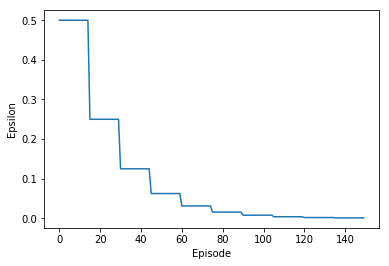

In [28]:
eps = 0.5
epis = 150
epoch = 15

plt.plot([eps*((1-eps)**(i//epoch)) for i in range(epis)])
plt.xlabel('Episode')
plt.ylabel('Epsilon');

### Running Sarsa and Q-learning 

In [29]:
# Sarsa converges to the safe path, while Q-Learning converges to the optimal path
# episodes of each run

policy='sarsa'
episodes = 150#0
EPOCH = 15

runs = 1

rewards_sarsa = np.zeros(episodes)
rewards_q_learning = np.zeros(episodes)
for r in tqdm(range(runs)):
    q_sarsa = np.zeros((NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS)))
    q_q_learning = np.copy(q_sarsa)
    data_generator.rewind()
    for i in range(0, episodes):
        eps = EPSILON*((1-EPSILON)**(i//EPOCH))
        if policy == 'sarsa':
            rewards_sarsa[i] += sarsa(q_sarsa, eps=eps)
        else:
            rewards_q_learning[i] += q_learning(q_q_learning, eps=eps)

# Averaging over independent runs
rewards_sarsa /= runs
rewards_q_learning /= runs
print(rewards_sarsa[:10])

  0%|          | 0/1 [00:00<?, ?it/s]

we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached the end
we have reached 

100%|██████████| 1/1 [05:14<00:00, 314.25s/it]

we have reached the end
[10731.    888.4 10780.5   884.7 10876.1   905.3 10812.5   917.7 10955.6
   936. ]


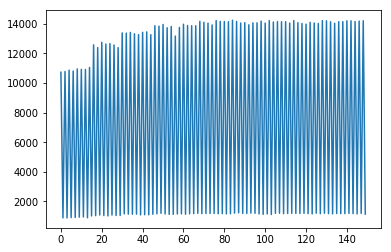

In [50]:
plt.plot(rewards_sarsa, label='Sarsa');

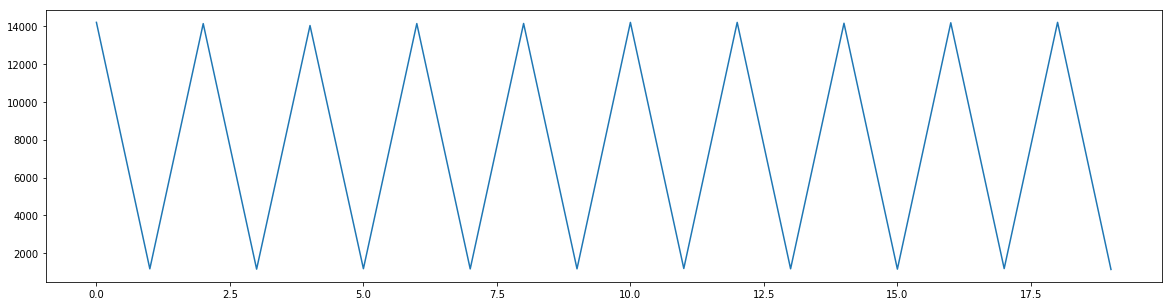

In [48]:
plt.figure(figsize=(20,5))
plt.plot(rewards_sarsa[-20:], label='Sarsa');

Sarsa Optimal Policy:
ask fill prob: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
flat: b,b,b,b,b,s,s,s,s,s,
short: b,b,b,b,b,b,b,b,b,h,
long: s,s,s,s,s,s,s,s,s,s,


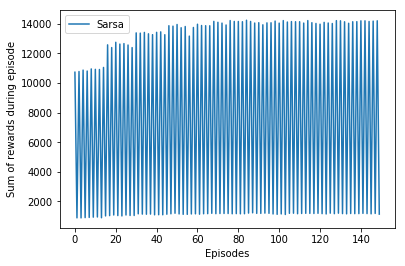

In [32]:
# Draw reward curves
if policy=='sarsa':
    plt.plot(rewards_sarsa, label='Sarsa')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.legend()

    print('Sarsa Optimal Policy:')
    print_optimal_policy(q_sarsa)

else:
    plt.plot(rewards_q_learning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.legend()

    print('Q-Learning Optimal Policy:')
    print_optimal_policy(q_q_learning)


In [24]:
# Sarsa converges to the safe path, while Q-Learning converges to the optimal path
def figure_6_4(policy):
    if policy not in ['sarsa', 'q-learning']:
        raise ValueError("choose 'sarsa' or 'q-learning'")
    
    # episodes of each run
    episodes = 15#0
    EPOCH = 15

    runs = 1

    rewards_sarsa = np.zeros(episodes)
    rewards_q_learning = np.zeros(episodes)
    for r in tqdm(range(runs)):
        q_sarsa = np.zeros((NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS)))
        q_q_learning = np.copy(q_sarsa)
        data_generator.rewind()
        for i in range(0, episodes):
            eps = EPSILON*((1-EPSILON)**(i//EPOCH))
            if policy=='sarsa':
                rewards_sarsa[i] += sarsa(q_sarsa, eps=eps)
            else:
                rewards_q_learning[i] += q_learning(q_q_learning, eps=eps)

    # Averaging over independent runs
    rewards_sarsa /= runs
    rewards_q_learning /= runs
    print(rewards_sarsa[:10])
    
    # Draw reward curves
    if policy=='sarsa':
        plt.plot(rewards_sarsa, label='Sarsa')
        plt.xlabel('Episodes')
        plt.ylabel('Sum of rewards during episode')
        plt.legend()
        print('Sarsa Optimal Policy:')
        print_optimal_policy(q_sarsa)
        return q_sarsa
        
    else:
        plt.plot(rewards_q_learning, label='Q-Learning')
        plt.xlabel('Episodes')
        plt.ylabel('Sum of rewards during episode')
        plt.legend()

        print('Q-Learning Optimal Policy:')
        print_optimal_policy(q_q_learning)
        return q_q_learning
    plt.show()


In [40]:
q_sarsa= figure_6_4('sarsa')
q_q_learning = figure_6_4('q-learning')

  0%|          | 0/1 [00:00<?, ?it/s]

[11461.2 11546.  11652.6 11655.5 11906.7 11683.4 11707.9 11780.6 11648.2
 11568.2]
Sarsa Optimal Policy:
ask fill prob: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
flat: b,b,b,b,b,b,b,b,s,s,
short: b,b,b,b,b,b,b,b,b,b,
long: h,s,s,s,s,s,s,s,s,s,


100%|██████████| 1/1 [01:02<00:00, 62.37s/it]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Q-Learning Optimal Policy:
ask fill prob: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
flat: b,b,b,b,b,s,s,s,s,s,
short: b,b,b,b,b,b,b,b,b,b,
long: h,s,s,s,s,s,s,s,s,s,


### Running Sarsa, Expected Sarsa and Q-learning to compare their asymptotic behavior

In [33]:
# Due to limited capacity of calculation of my machine, I can't complete this experiment
# with 100,000 episodes and 50,000 runs to get the fully averaged performance
# However even I only play for 500 episodes and 1000 steps per episode, the curves looks still good.
# MFD: not finished yet.
def figure_6_6():
    step_sizes = np.arange(0.01, 0.2, 0.04)
    episodes = 10#0
    runs = 1

    ASY_SARSA = 0
    ASY_EXPECTED_SARSA = 1
    ASY_QLEARNING = 2
    INT_SARSA = 3
    INT_EXPECTED_SARSA = 4
    INT_QLEARNING = 5
    methods = range(0, 6)

    performace = np.zeros((6, len(step_sizes)))
    for run in range(runs):
        for ind, step_size in tqdm(list(enumerate(step_sizes))):
            q_sarsa = np.zeros((NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS)))
            q_expected_sarsa = np.copy(q_sarsa)
            q_q_learning = np.copy(q_sarsa)
            for ep in range(episodes):
                sarsa_reward = sarsa(q_sarsa, expected=False, step_size=step_size, eps=0.1)
                expected_sarsa_reward = sarsa(q_expected_sarsa, expected=True, step_size=step_size, eps=0.1)
                q_learning_reward = q_learning(q_q_learning, step_size=step_size, eps=0.1)
                performace[ASY_SARSA, ind] += sarsa_reward
                performace[ASY_EXPECTED_SARSA, ind] += expected_sarsa_reward
                performace[ASY_QLEARNING, ind] += q_learning_reward

                if ep < 100:
                    performace[INT_SARSA, ind] += sarsa_reward
                    performace[INT_EXPECTED_SARSA, ind] += expected_sarsa_reward
                    performace[INT_QLEARNING, ind] += q_learning_reward

    performace[:3, :] /= episodes * runs
    performace[3:, :] /= 100 * runs
    labels = ['Asymptotic Sarsa', 'Asymptotic Expected Sarsa', 'Asymptotic Q-Learning',
              'Interim Sarsa', 'Interim Expected Sarsa', 'Interim Q-Learning']

    for method, label in zip(methods, labels):
        plt.plot(step_sizes, performace[method, :], label=label)
    plt.xlabel('alpha')
    plt.ylabel('reward per episode')
    plt.legend()

  0%|          | 0/5 [00:00<?, ?it/s]

we have reached the end


 20%|██        | 1/5 [00:09<00:37,  9.33s/it]

we have reached the end


 40%|████      | 2/5 [00:18<00:27,  9.26s/it]

we have reached the end


 60%|██████    | 3/5 [00:27<00:18,  9.07s/it]

we have reached the end


 80%|████████  | 4/5 [00:36<00:09,  9.20s/it]

we have reached the end


100%|██████████| 5/5 [00:47<00:00,  9.46s/it]


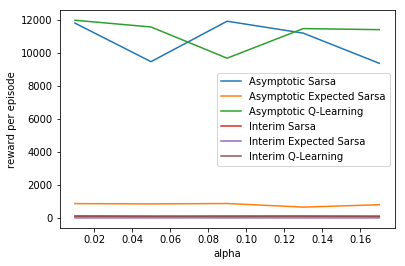

In [34]:
figure_6_6()

### Run animation of the market-making according to the learned policies for one episode

In [59]:
%matplotlib inline

In [ ]:
fig = plt.figure(figsize=(12, 8))

gs = GridSpec(2,2) # 2 rows, 2 columns

ax1 = fig.add_subplot(gs[0,0]) # First row, first column
ax2 = fig.add_subplot(gs[0,1]) # First row, second column
ax3 = fig.add_subplot(gs[1,0]) # Second row, first column

t = 20
bids = []
asks = []
bid_fills = []
xdata = []
pnl = []

objects = ['bid','ask']
y_pos = range(len(objects))


done = False
state = START
rewards = 0.0
iteration = 0

# Run one episode for SARSA
while iteration < MAX_ITER and not done:
    
    action = np.argmax(q_sarsa[state[0], state[1], :]) #this is SARSA, change to q_learning to check out Q-learning algorithm
    
    state, reward, done = step(state, action)
    iteration += 1
    
    position_name = [name for name, pos in positions.items() if pos == state[0]][0] 
    action_name = [name for name, act in actions.items() if act == action][0]                    
    prices = state[2]
    
    # Cumulative PnL
    if len(pnl)==0:
        pnl.append(reward)
    else: 
        pnl.append(pnl[-1]+reward)
        
    # Prices
    bids.append(prices['bid'])
    asks.append(prices['ask'])
    xdata.append(iteration)
    ax1.clear()
    ax1.plot(xdata, bids, color = 'black')
    ax1.plot(xdata, asks, color = 'black')
    ax1.set_ylabel('Prices')
    ax1.set_xlabel('Iteration')
    ax1.set_title('Cumulated PnL: ' + "%.2f" % pnl[-1] + ' ~ ' +
                 'Position: ' + position_name + ' ~ ' +
                 'Entry Price: ' + "%.2f" % state[-1])
    ax1.set_xlim([max(0, iteration - 80.5), iteration + 0.5])
    
    # Plotting actions according to the Policy
    if (action == actions['sell']):
        ax1.scatter(iteration, prices['bid']+0.03, color='orangered', marker='v',  s=50)
    elif (action == actions['buy']).all():
        ax1.scatter(iteration, prices['ask']-0.03, color='lawngreen', marker='^', s=50)
    
    # Ploting PnL
    ax2.clear()
    ax2.plot(xdata, pnl)
    ax2.set_ylabel('Total PnL')
    ax2.set_xlabel('Iteration')
    
    # Plotting current probabilities to fill
    q_a = FILL_PROBS[state[1]]
    q_b = 1 - q_a
    performance = [q_b, q_a]
    
    ax3.clear()
    ax3.bar(y_pos, performance, align='center', alpha=0.5, color=['orangered','lawngreen'])
    ax3.set_xticks(y_pos)
    ax3.set_xticklabels(objects)
    ax3.set_title('Probability of fill')
    ax3.set_ylim([0, 1])
    fig.tight_layout()
    time.sleep(0.5)